##### As we all know option contracts pricing is governed by:

    - the price of the underlying stock relative to the strike price
    - the volatility of the underlying stock
    - how much time is left until the option expires

##### Currently, we are trying to predict the realized volatility of individual options contracts using intraday pricing data. However, this approach is flawed because of several factors:

    1. The options contracts have extremely noisy data.
        - there are all sorts of oscillations, pricing anomalies, things that we have formulated can be addressed with metrics such as measuring the number of delta price changes, the max unidirectional change, etc.
        - even if we were to accurately detect what is noise and what isn't, there comes the challenge of excluding what is noise and what isn't
    2. The options contracts are all correlated with each other, and the underlying stock, thus to best predict volatility on any given contract, we must use a lookback across multiple contracts and the underlying stock itself.
        - this obviously increases training complexity, combined with the fact that the correlations are not perfect as contracts that are already intrinsically worth something have different correlation factors than contracts that are not intrinsically worth anything yet.
        - furthermore, comes the challenge of combining these correlations given the fact that options that have lower liquidity would have noisier data that would make extracting measurable signals all the more difficult.

##### Thus I propose we take a step back and tackle something that I believe will be easier, predicting the realized volatility of the stock pricing data itself. 
##### The SPY stock is very dense, but it is not nearly as noisy as the options data due to having much higher trading volume. Furthermore, the approach to predicting the realized volatility on the underlying stock itself is not that different of a problem from predicting the realized volatility of the option contracts, with the added bonus that the stock realized volatility is the bedrock of the realized volatility on the options which means we would be killing two birds with one stone.


In [2]:
import sys
sys.path.append("/home/luke/Documents/GitHub/Data_Handling")

import numpy as np
import pandas as pd
from Most_Recent_NBBO_Candling.Options_NBBO_Candling import options_NBBO_candle
from Most_Recent_NBBO_Candling.Stock_NBBO_Candling import stock_NBBO_candle
from Training_Features.realized_volatiliity import realized_vol
from Training_Features.unidirectional_change import maxLoss_list, maxProfit_list
import matplotlib.pyplot as plt
import seaborn as sns

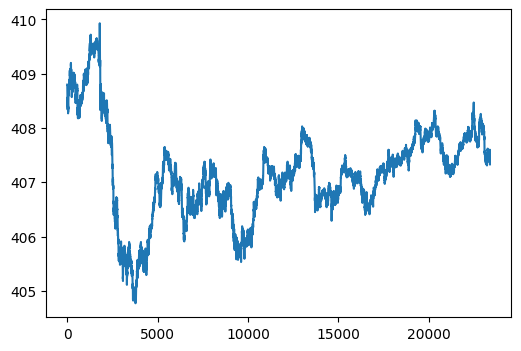

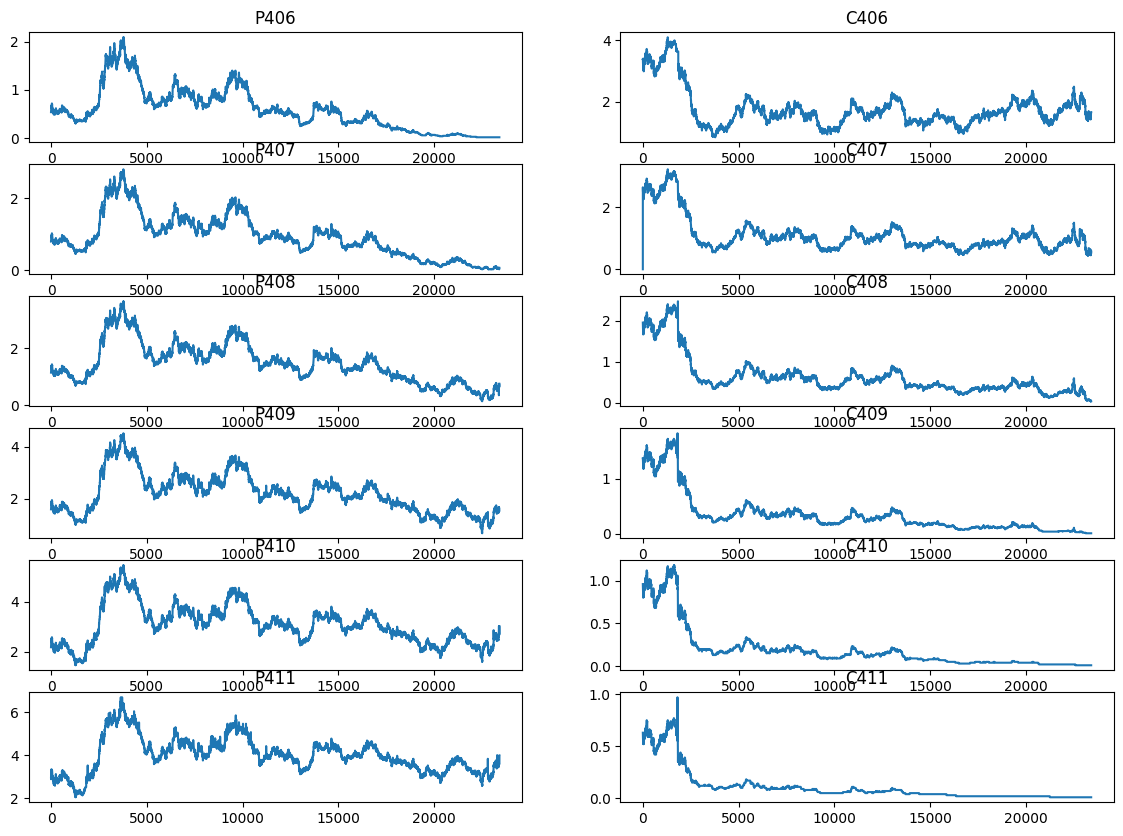

In [3]:
puts = ["P406", "P407", "P408", "P409", "P410", "P411"]
calls = ["C406", "C407", "C408", "C409", "C410", "C411"]
path = "/srv/sqc/volatility_exploration/NBBO_Candled/Most_Recent_Protocol/Options_Data/20221201/"

underlying_price = pd.read_csv("/srv/sqc/volatility_exploration/NBBO_Candled/Most_Recent_Protocol/Stock_Data/20221201.csv")["Ask"].to_list()
puts_prices = [pd.read_csv(path + puts[x] + ".csv")['Ask'].tolist() for x in range(len(puts))]
calls_prices = [pd.read_csv(path + calls[x] + ".csv")['Ask'].tolist() for x in range(len(calls))]
plt.figure(figsize=(6, 4))
plt.plot(underlying_price)

fig, axs = plt.subplots(6, 2, figsize=(14,10))

for ind in range(len(puts)):
    axs[ind][0].plot(puts_prices[ind])
    axs[ind][0].set_title(puts[ind])


for ind in range(len(calls)):
    axs[ind][1].plot(calls_prices[ind])
    axs[ind][1].set_title(calls[ind])

plt.show()

##### The first graph is the SPY price over the course of the day. The 12 graphs below the SPY price chart are the calls and puts that have strike that are within $5 of the underlying stock at open. As seen, the calls share a visible correlation with each other, as do the puts. To see the exact relationship, in the cell below I create a heatmap of the correlations.

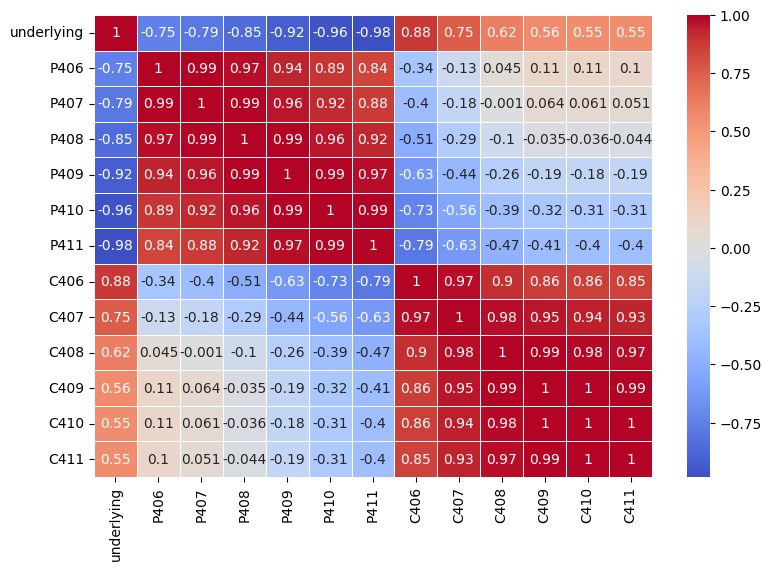

In [4]:
df = pd.DataFrame()
df['underlying'] = underlying_price

for ind in range(len(puts)):
    df[puts[ind]] = puts_prices[ind]

for ind in range(len(calls)):
    df[calls[ind]] = calls_prices[ind]

correlation_matrix = df.corr()


plt.figure(figsize=(9, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=.5)
plt.show()


##### Unsurprisingly, the calls and puts share high correlations with each other. Furthermore, the calls have a positive correlation with the SPY price chart, while the puts have a negative correlation. Moreover, as the calls and puts are not in the money have a weaker correlation. Fortunately, this correlation factor between options at different strike prices and the underlying stock can be modeled using the black scholes model. 
##### This is why I propose predicting volatility on the underlying stock itself. Because if we accomplish this, we can easily transfer those results over the options by rescaling it using a secondary neural network that maps out the scaled volatility for each optoins contract.

[0.02961676 0.02964911 0.02970939 ... 0.06732394 0.06732098 0.05640082]
[4.06732409e-06 4.06732409e-06 4.10571813e-06 ... 2.30569265e-06
 2.30629519e-06 2.16747600e-06]


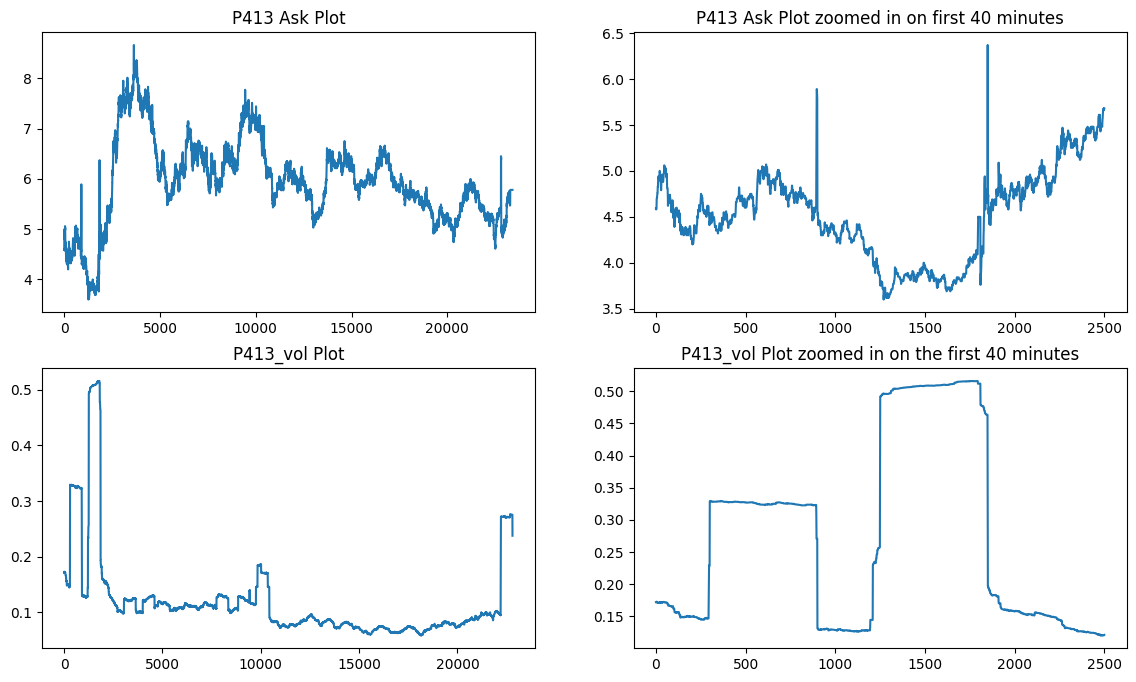

In [8]:
p413_path = "/srv/sqc/data/us-options-tanq/us-options-tanq-2022/20221201/S/SPY/SPY.20221201/Candles.SPY.P413.20221201.csv"
p413_ask = pd.read_csv(p413_path)['PriceAskMin'].tolist()[1:]
p413_vol = realized_vol(p413_ask, 600)

underlying_vol = realized_vol(underlying_price, 600)

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[0][0].plot(p413_ask)
axs[1][0].plot(p413_vol)[1:]
axs[0][0].set_title("P413 Ask Plot")
axs[1][0].set_title("P413_vol Plot")

axs[0][1].plot(p413_ask[:2500])
axs[1][1].plot(p413_vol[:2500])
axs[0][1].set_title("P413 Ask Plot zoomed in on first 40 minutes")
axs[1][1].set_title("P413_vol Plot zoomed in on the first 40 minutes")

plt.show()


##### As mentioned at the beginning of this notebook, noise in the options pricing data creates issues. For instance, in the first 40 minutes there exists two anomolous price movement. These graphs above show them. And while these movements happen across mere seconds, looking at the realized volatility metric calculated over a 10 minute window, they create immense outliers and skew the feature alot. This issue from my understanding occurs because in the old methodology the candling takes the lowest possible ask at every second. Theoretically this would return the lowest price at which we can purchase said option contract. However, clearly these prices are too anamolous to be true. Thus I have adopted a new candling method using NBBO pricing data.

##### The example above illustrates the current pr

[0.02536213 0.02542717 0.0255706  ... 0.06918804 0.06918804 0.06918804]
[4.06732409e-06 4.06732409e-06 4.10571813e-06 ... 2.30569265e-06
 2.30629519e-06 2.16747600e-06]


Text(0.5, 1.0, 'P413_vol Plot zoomed in on the first 40 minutes')

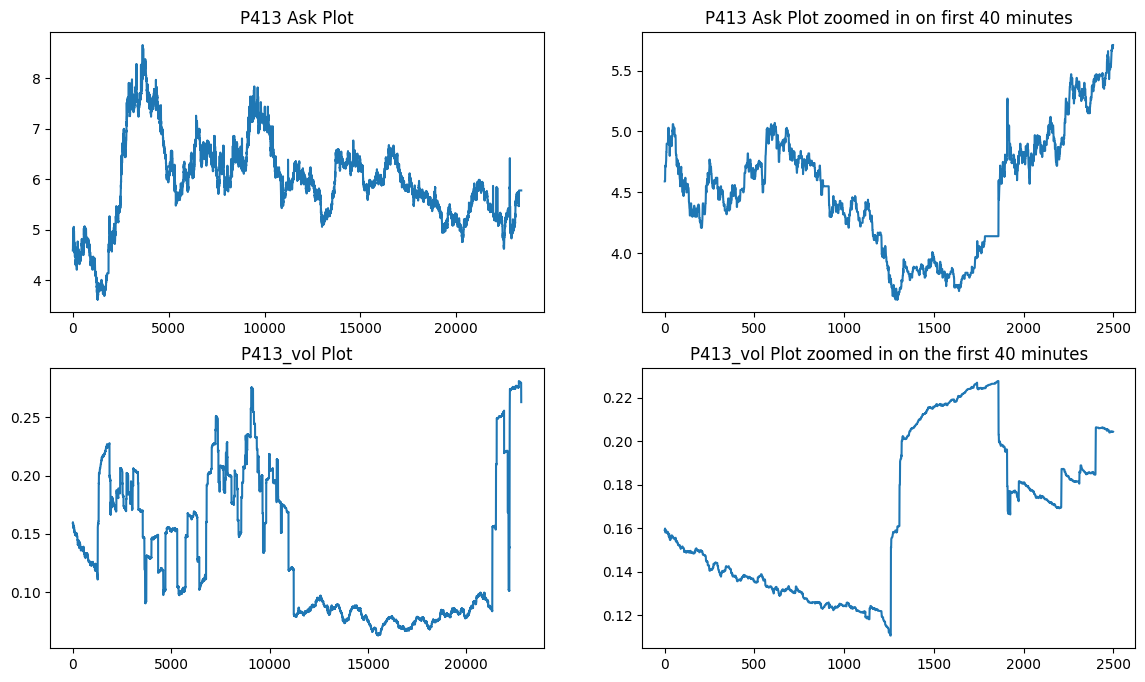

In [9]:
p413_path = "/srv/sqc/volatility_exploration/NBBO_Candled/Most_Recent_Protocol/Options_Data/20221201/P413.csv"
p413_ask = pd.read_csv(p413_path)['Ask'].tolist()[1:]
p413_vol = realized_vol(p413_ask, 600)



fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[0][0].plot(p413_ask)
axs[1][0].plot(p413_vol)[1:]
axs[0][0].set_title("P413 Ask Plot")
axs[1][0].set_title("P413_vol Plot")

axs[0][1].plot(p413_ask[:2500])
axs[1][1].plot(p413_vol[:2500])
axs[0][1].set_title("P413 Ask Plot zoomed in on first 40 minutes")
axs[1][1].set_title("P413_vol Plot zoomed in on the first 40 minutes")

##### Using the last NBBO ask at each second for the candling seems to have reduced the noise since NBBO asks are tabeulated by OPRA's algorithms that compile the best possible ask across the different exchanges. This introduces less noise into the data as OPRA does vetting to ensure that the prices being reported are real. However, there is still some noise as seen in these graphs.

[2.97784230e-06 2.97245674e-06 2.98745404e-06 ... 1.67819952e-06
 1.68000813e-06 1.57724197e-06]


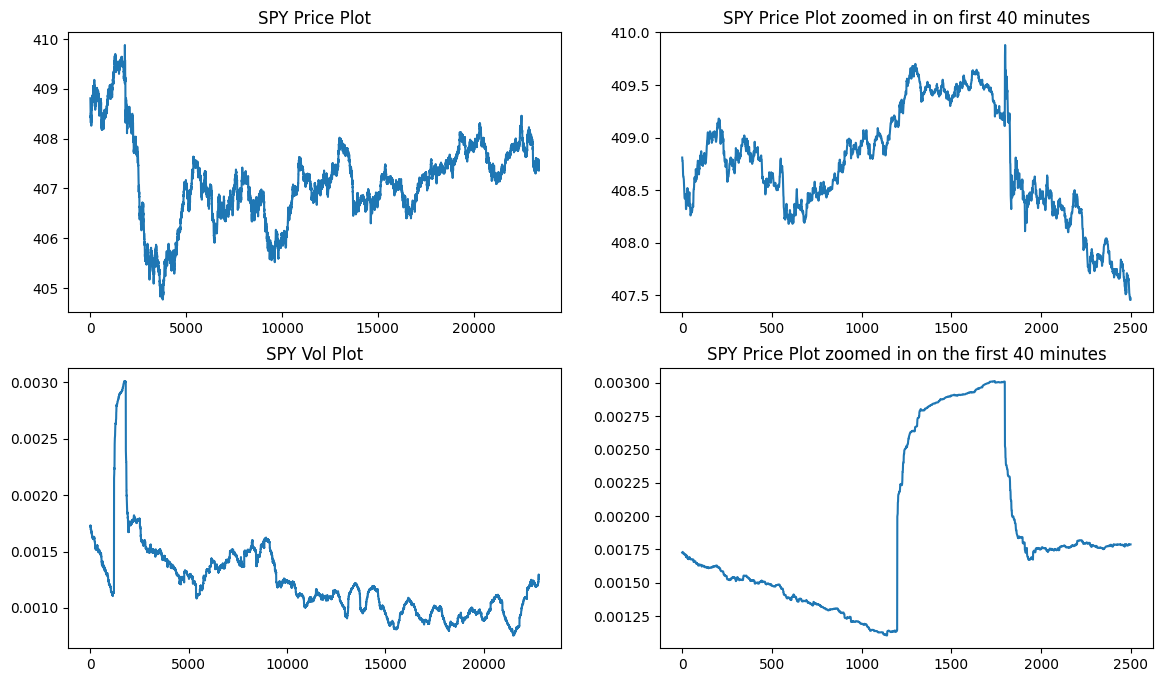

In [25]:
underlying_price = pd.read_csv("/srv/sqc/data/client-2378-luke-eq-taq/2022/20221201/S/Candles.SPY.csv")["Price"].tolist()
underlying_vol = realized_vol(underlying_price, 600)

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[0][0].plot(underlying_price)
axs[1][0].plot(underlying_vol)
axs[0][0].set_title("SPY Price Plot")
axs[1][0].set_title("SPY Vol Plot")

axs[0][1].plot(underlying_price[:2500])
axs[1][1].plot(underlying_vol[:2500])
axs[0][1].set_title("SPY Price Plot zoomed in on first 40 minutes")
axs[1][1].set_title("SPY Price Plot zoomed in on the first 40 minutes")

plt.show()

##### As it turns out however, the noise observed in the cleaned option price, in this instance is also observed in the SPY stock, I am currently exploring other possible ways to recandle the data to further clean anomolies such as the observed one here since they dramatically effect the volatility. One solution, is to predict not just the realized_volatility but also the maximum profit and or loss possible in a given window.
##### The maximum profit and loss features are exactly what they sound like, given the price data, these features return what is the maximum profit possible by buying low and selling high, or vice versa. This is useful because being able to accurately predict these metrics would allow us to know what kind of opportunities lie.

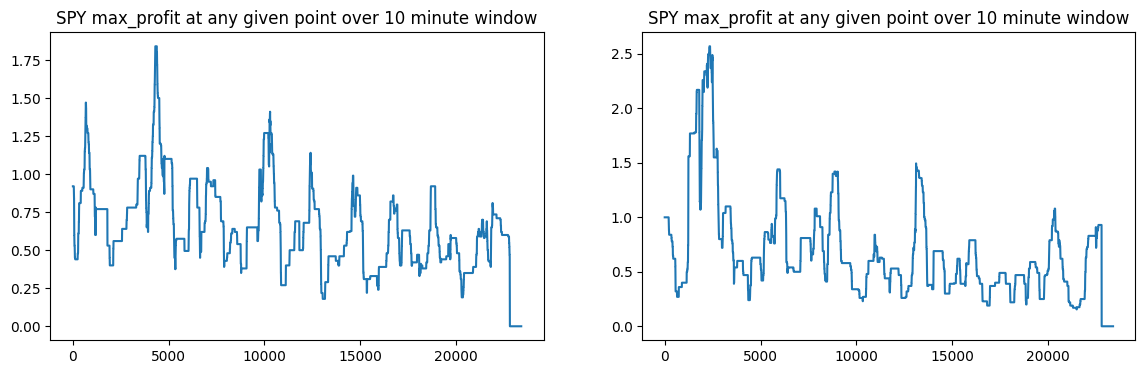

In [28]:
max_profit = maxProfit_list(underlying_price, 600)
max_losses = maxLoss_list(underlying_price, 600)

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].plot(max_profit)
axs[1].plot(max_losses)

axs[0].set_title("SPY max_profit at any given point over 10 minute window")
axs[1].set_title("SPY max_profit at any given point over 10 minute window")

plt.show()